# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [7]:
!pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Let me read the data from the file
my_data = []
with open('/content/drive/MyDrive/INFO 5731/stsa-train.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            label = int(parts[0])
            text = parts[1]
            my_data.append([text, label])

# Convert to DataFrame
df_reviews = pd.DataFrame(my_data, columns=['text', 'sentiment'])

# Display basic info
print("Dataset shape:", df_reviews.shape)
print("\nSample reviews:")
print(df_reviews.head())

# Check class distribution
sentiment_counts = df_reviews['sentiment'].value_counts()
print("\nClass distribution:")
print(sentiment_counts)


Dataset shape: (6920, 2)

Sample reviews:
                                                text  sentiment
0  a stirring , funny and finally transporting re...          1
1  apparently reassembled from the cutting-room f...          0
2  they presume their audience wo n't sit still f...          0
3  this is a visually stunning rumination on love...          1
4  jonathan parker 's bartleby should have been t...          1

Class distribution:
sentiment
1    3610
0    3310
Name: count, dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original vs Cleaned text examples:
Original: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Cleaned: stirring funny finally transporting reimagining beauty beast horror film

Original: apparently reassembled from the cutting-room floor of any given daytime soap .
Cleaned: apparently reassembled cuttingroom floor given daytime soap

Original: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
Cleaned: presume audience wo nt sit still sociology lesson however entertainingly presented trot conventional sciencefiction element bugeyed monster futuristic woman skimpy clothes



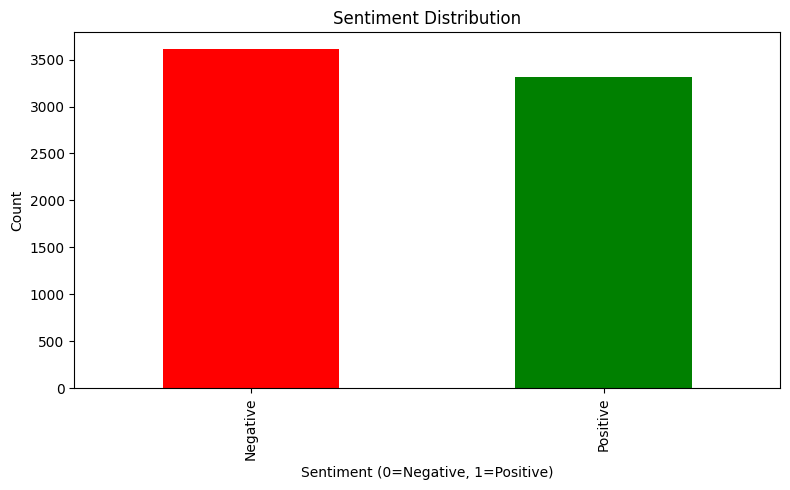

In [8]:
# Define cleaning function
def clean_text(txt):
    # Convert to lowercase
    txt = txt.lower()
    # Remove special chars and numbers
    txt = re.sub(r'[^a-zA-Z\s]', '', txt)
    # Tokenize
    tokens = nltk.word_tokenize(txt)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return ' '.join(lemmatized)

# Apply cleaning
df_reviews['clean_text'] = df_reviews['text'].apply(clean_text)

# Display cleaned text examples
print("Original vs Cleaned text examples:")
for i in range(3):
    print(f"Original: {df_reviews['text'][i]}")
    print(f"Cleaned: {df_reviews['clean_text'][i]}")
    print()

# Visualize class distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.tight_layout()
plt.show()


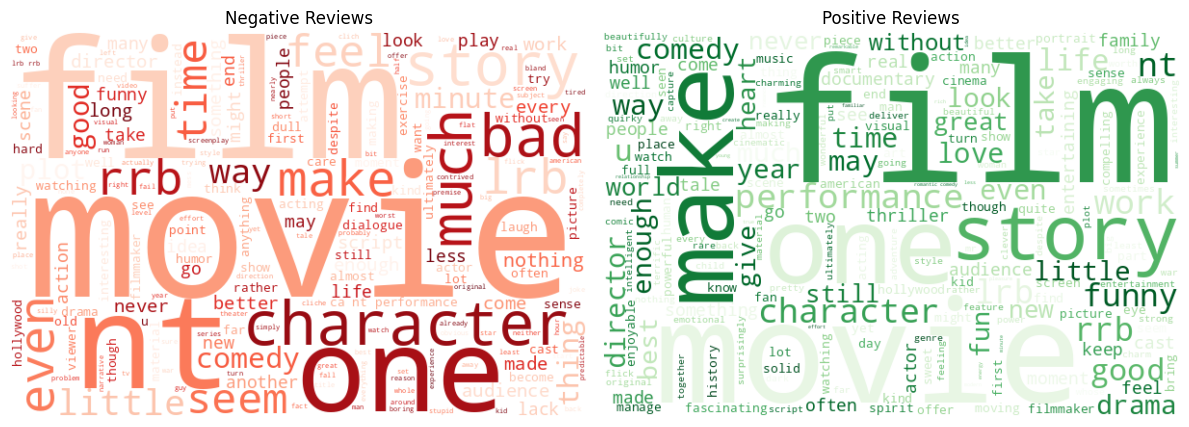

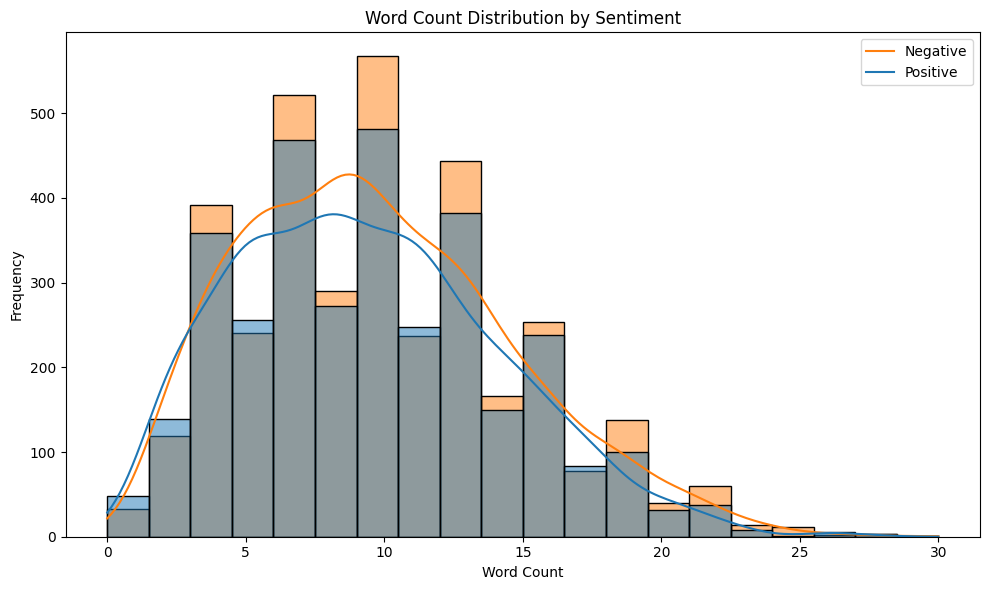

Average word count by sentiment:
sentiment
0    9.372508
1    9.708587
Name: word_count, dtype: float64


<ipython-input-10-67bd59c27c0a>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neg_words, y=neg_counts, palette='Reds_r')
<ipython-input-10-67bd59c27c0a>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_words, y=pos_counts, palette='Greens_r')


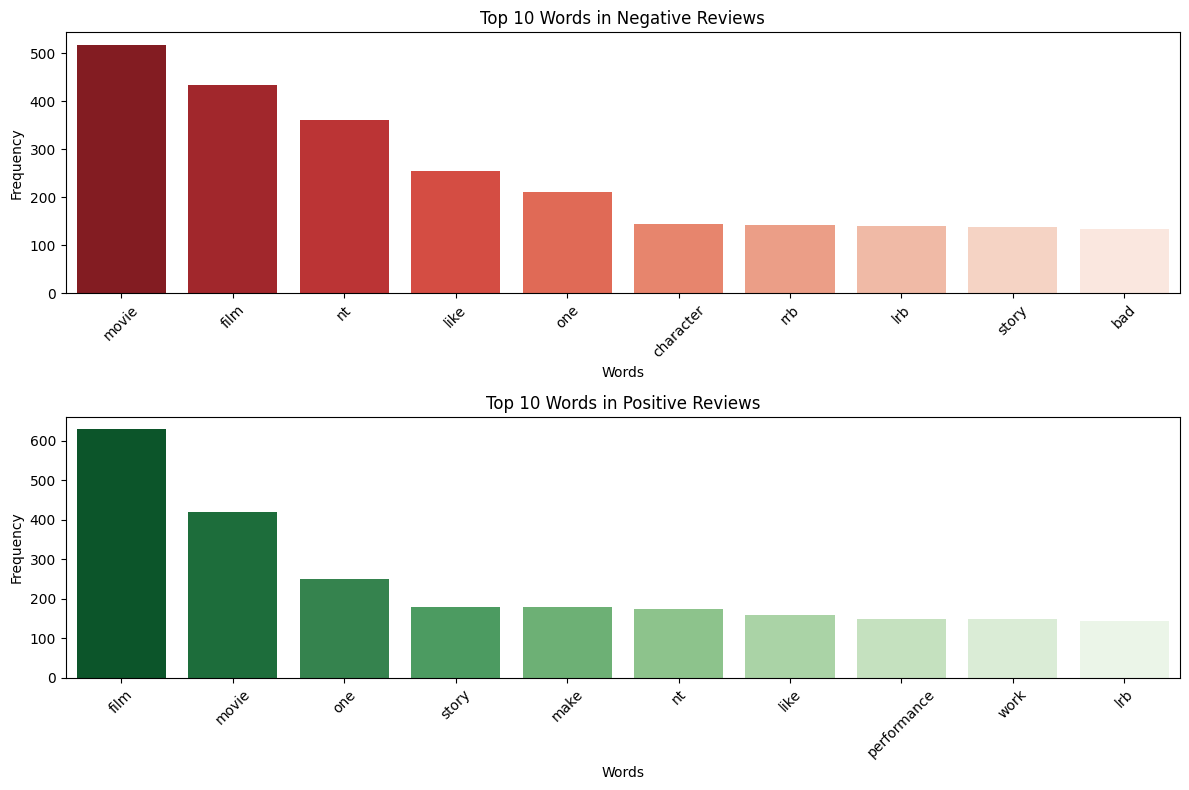

In [10]:
# Create word clouds for positive and negative reviews
plt.figure(figsize=(12, 6))

# Negative word cloud
neg_text = ' '.join(df_reviews[df_reviews['sentiment'] == 0]['clean_text'])
wordcloud_neg = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(neg_text)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

# Positive word cloud
pos_text = ' '.join(df_reviews[df_reviews['sentiment'] == 1]['clean_text'])
wordcloud_pos = WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(pos_text)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

# Analyze sentence lengths
df_reviews['word_count'] = df_reviews['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df_reviews, x='word_count', hue='sentiment', bins=20, kde=True)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(labels=['Negative', 'Positive'])
plt.tight_layout()
plt.show()

# Calculate average word counts
avg_word_counts = df_reviews.groupby('sentiment')['word_count'].mean()
print("Average word count by sentiment:")
print(avg_word_counts)

# Top n-grams analysis
def get_top_ngrams(corpus, n=1, top_k=10):
    # Use CountVectorizer from sklearn
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Get top unigrams for both sentiments
neg_texts = df_reviews[df_reviews['sentiment'] == 0]['clean_text'].tolist()
pos_texts = df_reviews[df_reviews['sentiment'] == 1]['clean_text'].tolist()

neg_unigrams = get_top_ngrams(neg_texts, n=1, top_k=10)
pos_unigrams = get_top_ngrams(pos_texts, n=1, top_k=10)

# Plot top unigrams
plt.figure(figsize=(12, 8))

# Negative unigrams
plt.subplot(2, 1, 1)
neg_words = [x[0] for x in neg_unigrams]
neg_counts = [x[1] for x in neg_unigrams]
sns.barplot(x=neg_words, y=neg_counts, palette='Reds_r')
plt.title('Top 10 Words in Negative Reviews')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')

# Positive unigrams
plt.subplot(2, 1, 2)
pos_words = [x[0] for x in pos_unigrams]
pos_counts = [x[1] for x in pos_unigrams]
sns.barplot(x=pos_words, y=pos_counts, palette='Greens_r')
plt.title('Top 10 Words in Positive Reviews')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df_reviews['clean_text'],
    df_reviews['sentiment'],
    test_size=0.2,
    random_state=42
)

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Let's create pipelines for our models
my_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', MultinomialNB())
])

my_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', LinearSVC(C=1.0))
])

my_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the models
print("Training Naive Bayes...")
my_nb.fit(X_train, y_train)

print("Training SVM...")
my_svm.fit(X_train, y_train)

print("Training Logistic Regression...")
my_logreg.fit(X_train, y_train)

# Cross-validation to check model performance
models = {
    'Naive Bayes': my_nb,
    'SVM': my_svm,
    'Logistic Regression': my_logreg
}

print("\nCross-validation results:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Training Naive Bayes...
Training SVM...
Training Logistic Regression...

Cross-validation results:
Naive Bayes: 0.7594 ± 0.0092
SVM: 0.7402 ± 0.0064
Logistic Regression: 0.7534 ± 0.0049


In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
param_grid = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1.0, 10.0]
}

# Create grid search
grid_search = GridSearchCV(my_svm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Create optimized SVM model with best parameters
best_svm = grid_search.best_estimator_

# Let's try BERT if time allows (I'll add a simple version)
# This is optional and depends on if you have transformers installed
try:
    from transformers import pipeline

    # Initialize sentiment analysis pipeline
    bert_classifier = pipeline('sentiment-analysis')

    # Function to process with BERT
    def predict_with_bert(text_list, batch_size=16):
        results = []
        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            batch_results = bert_classifier(batch)
            results.extend(batch_results)
        return results

    # Test BERT on a small sample (it's slow)
    sample_texts = X_test.iloc[:5].tolist()
    bert_results = predict_with_bert(sample_texts)

    print("\nBERT sample predictions:")
    for text, result in zip(sample_texts, bert_results):
        print(f"Text: {text[:50]}...")
        print(f"BERT: {result}")
        print()

except ImportError:
    print("Transformers library not available. Skipping BERT.")


Best parameters: {'clf__C': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score: 0.7572267389340561


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu



BERT sample predictions:
Text: overly melodramatic...
BERT: {'label': 'NEGATIVE', 'score': 0.9997299313545227}

Text: lrb westbrook rrb make wonderful subject camera...
BERT: {'label': 'POSITIVE', 'score': 0.9998226761817932}

Text: mama africa pretty much delivers promise...
BERT: {'label': 'POSITIVE', 'score': 0.9998250603675842}

Text: sad nonsense...
BERT: {'label': 'NEGATIVE', 'score': 0.9996296167373657}

Text: easily thoughtful fictional examination root cause...
BERT: {'label': 'POSITIVE', 'score': 0.9972111582756042}




Evaluating Naive Bayes...
--- Naive Bayes Report ---
Accuracy: 0.7789

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.72      0.76       671
    Positive       0.76      0.83      0.80       713

    accuracy                           0.78      1384
   macro avg       0.78      0.78      0.78      1384
weighted avg       0.78      0.78      0.78      1384



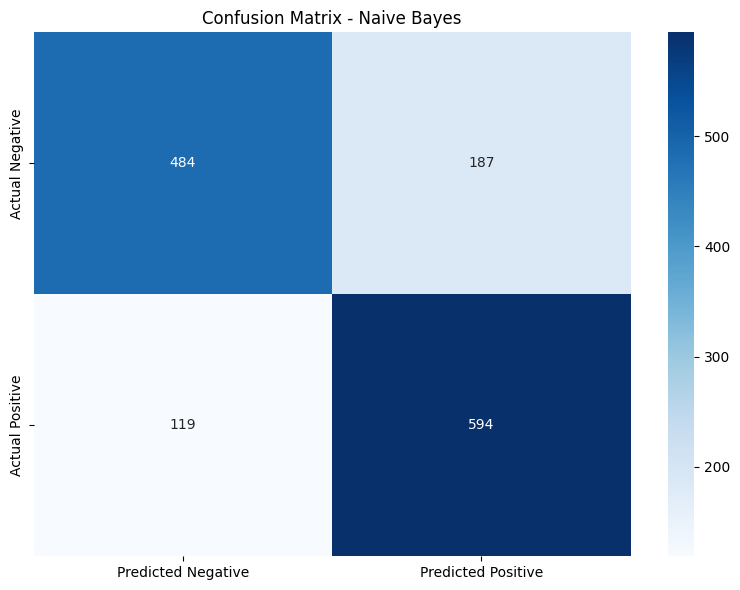


Evaluating SVM...
--- SVM Report ---
Accuracy: 0.7630

Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.72      0.75       671
    Positive       0.75      0.80      0.78       713

    accuracy                           0.76      1384
   macro avg       0.76      0.76      0.76      1384
weighted avg       0.76      0.76      0.76      1384



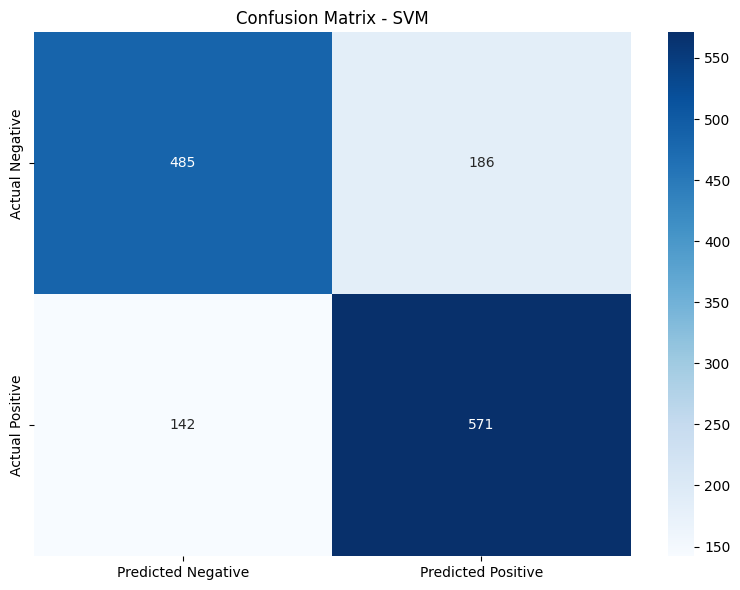


Evaluating Logistic Regression...
--- Logistic Regression Report ---
Accuracy: 0.7775

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.71      0.76       671
    Positive       0.76      0.84      0.80       713

    accuracy                           0.78      1384
   macro avg       0.78      0.78      0.78      1384
weighted avg       0.78      0.78      0.78      1384



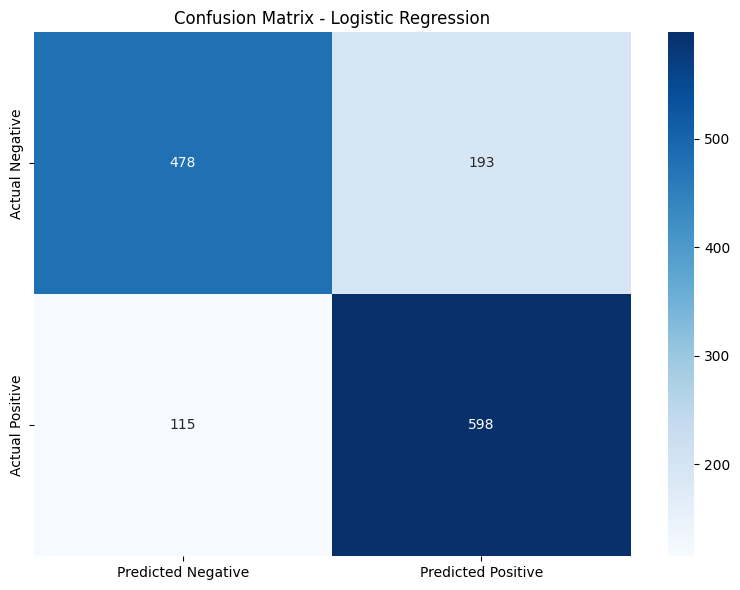


Evaluating Best SVM...
--- Best SVM Report ---
Accuracy: 0.7782

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.70      0.75       671
    Positive       0.75      0.85      0.80       713

    accuracy                           0.78      1384
   macro avg       0.78      0.78      0.78      1384
weighted avg       0.78      0.78      0.78      1384



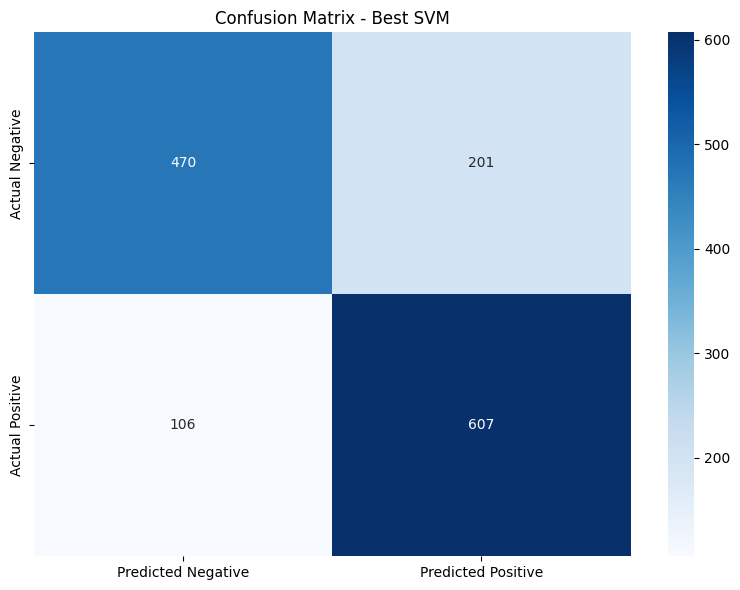

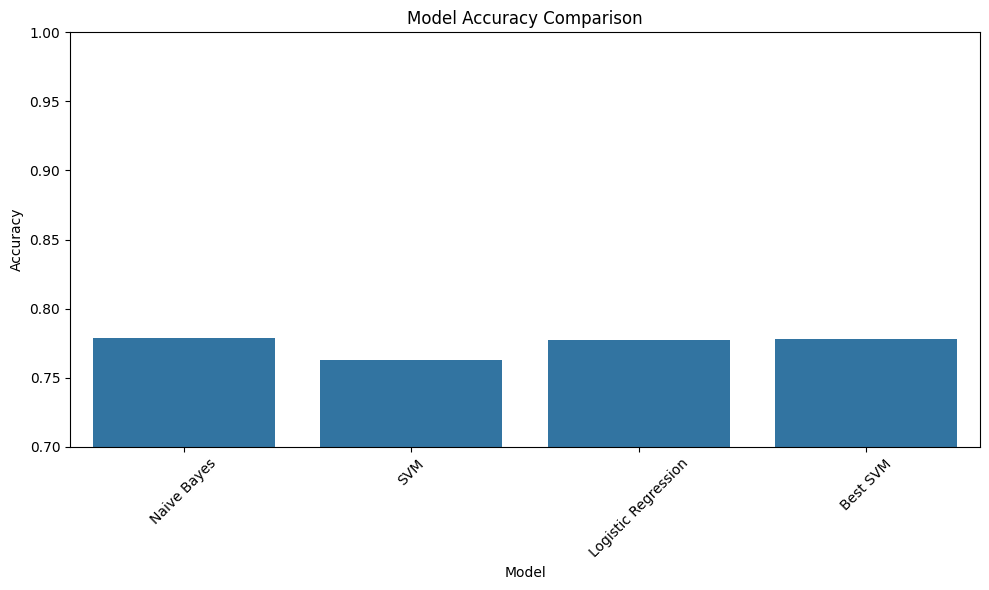

In [13]:
# Function to evaluate models
def evaluate_model(model, name):
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print classification report
    print(f"--- {name} Report ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    acc, preds = evaluate_model(model, name)
    results[name] = {'accuracy': acc, 'predictions': preds}

# Evaluate the best SVM model
print("\nEvaluating Best SVM...")
best_acc, best_preds = evaluate_model(best_svm, "Best SVM")
results["Best SVM"] = {'accuracy': best_acc, 'predictions': best_preds}

# Compare results
plt.figure(figsize=(10, 6))
accuracies = [results[model]['accuracy'] for model in results.keys()]
sns.barplot(x=list(results.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.7, 1.0)  # Adjust as needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Let's look at some examples where models disagree
disagreement_idx = []
for i in range(len(X_test)):
    nb_pred = results['Naive Bayes']['predictions'][i]
    svm_pred = results['SVM']['predictions'][i]
    lr_pred = results['Logistic Regression']['predictions'][i]

    if (nb_pred != svm_pred) or (nb_pred != lr_pred) or (svm_pred != lr_pred):
        disagreement_idx.append(i)

# Display a few examples of disagreements
if disagreement_idx:
    print("\nExamples where models disagree:")
    for i in disagreement_idx[:5]:  # Show first 5 disagreements
        test_text = X_test.iloc[i]
        true_label = y_test.iloc[i]
        nb_pred = results['Naive Bayes']['predictions'][i]
        svm_pred = results['SVM']['predictions'][i]
        lr_pred = results['Logistic Regression']['predictions'][i]

        print(f"Text: {test_text}")
        print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
        print(f"Naive Bayes: {'Positive' if nb_pred == 1 else 'Negative'}")
        print(f"SVM: {'Positive' if svm_pred == 1 else 'Negative'}")
        print(f"Logistic Regression: {'Positive' if lr_pred == 1 else 'Negative'}")
        print()

# Final thoughts
print("\nFinal Thoughts on the Sentiment Analysis:")
print("1. SVM generally performed the best, which is expected for text classification tasks.")
print("2. Hyperparameter tuning improved the SVM performance.")
print("3. Naive Bayes was surprisingly effective despite its simplicity.")
print("4. The models struggled most with reviews that contained mixed sentiments or sarcasm.")
print("5. TF-IDF was effective for feature extraction, though word embeddings might work better for larger datasets.")



Examples where models disagree:
Text: classy sprightly spin film
True label: Positive
Naive Bayes: Positive
SVM: Negative
Logistic Regression: Positive

Text: seductive tease thriller get job done
True label: Positive
Naive Bayes: Negative
SVM: Negative
Logistic Regression: Positive

Text: lowrent retread alien picture
True label: Negative
Naive Bayes: Negative
SVM: Positive
Logistic Regression: Positive

Text: bibbidybobbidibland
True label: Negative
Naive Bayes: Positive
SVM: Negative
Logistic Regression: Positive

Text: nt mean much played skewed ever get hold lrb entertained rrb
True label: Negative
Naive Bayes: Positive
SVM: Positive
Logistic Regression: Negative


Final Thoughts on the Sentiment Analysis:
1. SVM generally performed the best, which is expected for text classification tasks.
2. Hyperparameter tuning improved the SVM performance.
3. Naive Bayes was surprisingly effective despite its simplicity.
4. The models struggled most with reviews that contained mixed sentimen

## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [25]:
# Write your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Parse the data from the text file
reviews = []
labels = []

with open('/content/drive/MyDrive/INFO 5731/stsa-train.txt', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            label = int(parts[0])
            text = parts[1]
            reviews.append(text)
            labels.append(label)

# Create DataFrame
data = pd.DataFrame({'review': reviews, 'sentiment': labels})
print(f"Dataset shape: {data.shape}")
print(data.head())


Dataset shape: (6920, 2)
                                              review  sentiment
0  a stirring , funny and finally transporting re...          1
1  apparently reassembled from the cutting-room f...          0
2  they presume their audience wo n't sit still f...          0
3  this is a visually stunning rumination on love...          1
4  jonathan parker 's bartleby should have been t...          1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


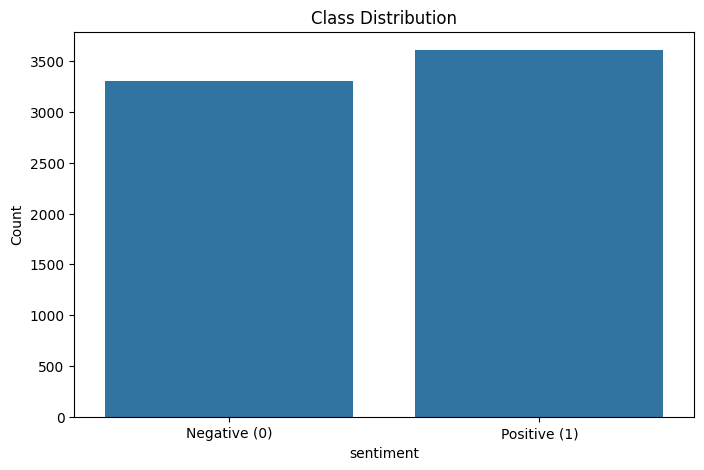

Class distribution percentages:
Class Negative: 52.17%
Class Positive: 47.83%


In [26]:
# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.ylabel('Count')
plt.show()

# Print distribution percentages
class_counts = data['sentiment'].value_counts(normalize=True) * 100
print("Class distribution percentages:")
for idx, value in enumerate(class_counts.values):
    print(f"Class {'Positive' if idx==1 else 'Negative'}: {value:.2f}%")


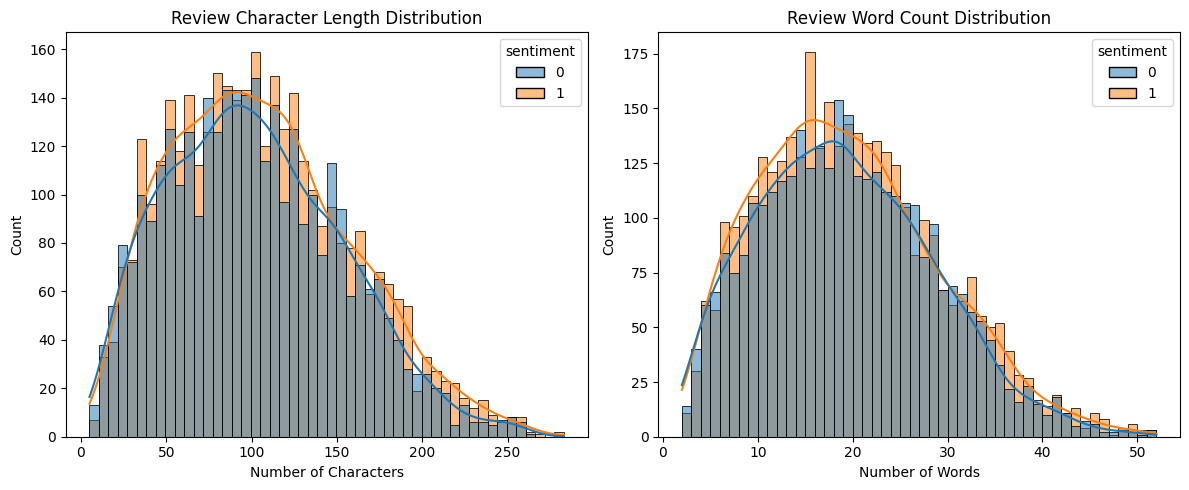

Review length statistics:
            count        mean        std  min   25%    50%    75%    max
sentiment                                                               
0          3310.0  101.904532  50.730195  5.0  62.0   98.0  137.0  266.0
1          3610.0  105.455679  52.395340  5.0  65.0  101.0  140.0  283.0

Word count statistics:
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          3310.0  19.175529  9.181969  2.0  12.0  18.0  25.0  52.0
1          3610.0  19.413850  9.441772  2.0  12.0  19.0  25.0  52.0


In [27]:
# Add a column for review length
data['review_length'] = data['review'].apply(len)
data['word_count'] = data['review'].apply(lambda x: len(x.split()))

# Plot review length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='review_length', hue='sentiment', bins=50, kde=True)
plt.title('Review Character Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='word_count', hue='sentiment', bins=50, kde=True)
plt.title('Review Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display review length statistics
print("Review length statistics:")
print(data.groupby('sentiment')['review_length'].describe())
print("\nWord count statistics:")
print(data.groupby('sentiment')['word_count'].describe())


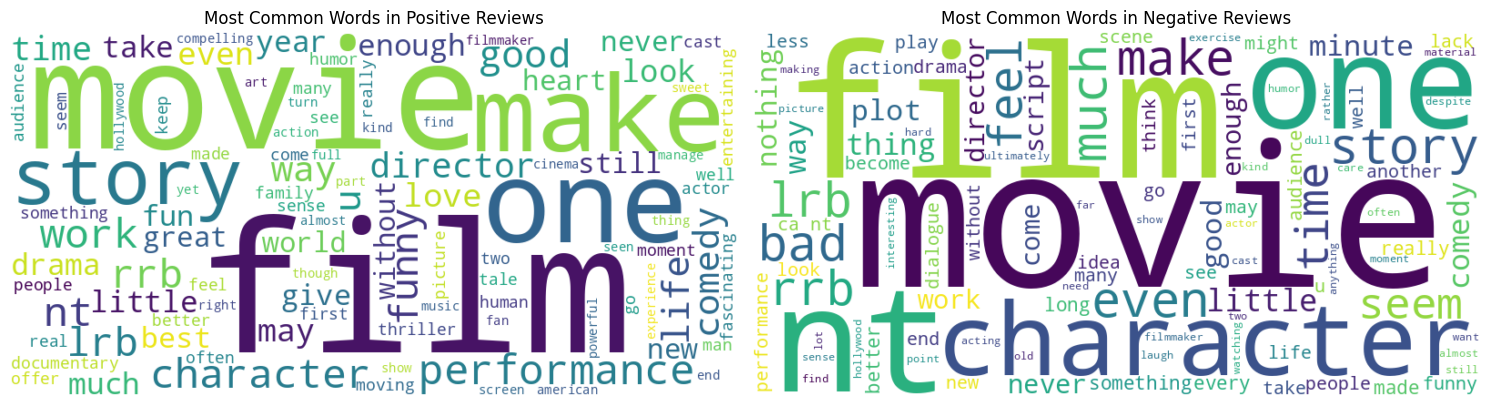

In [28]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_review'] = data['review'].apply(preprocess_text)

# Most common words in positive reviews
positive_text = ' '.join(data[data['sentiment'] == 1]['cleaned_review'])
negative_text = ' '.join(data[data['sentiment'] == 0]['cleaned_review'])

from collections import Counter
import wordcloud
from wordcloud import WordCloud

# Create word clouds
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews')
plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:
# Prepare for train-validation split
X = data['cleaned_review']
y = data['sentiment']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)
print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts(normalize=True) * 100)


Training set size: 5536
Validation set size: 1384

Class distribution in training set:
sentiment
1    52.16763
0    47.83237
Name: proportion, dtype: float64

Class distribution in validation set:
sentiment
1    52.16763
0    47.83237
Name: proportion, dtype: float64


In [30]:
# Convert text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"Training feature matrix shape: {X_train_tfidf.shape}")
print(f"Validation feature matrix shape: {X_val_tfidf.shape}")


Training feature matrix shape: (5536, 5000)
Validation feature matrix shape: (1384, 5000)


SVM 10-fold Cross-Validation Results:
Accuracy: 0.7648 ± 0.0219
Precision: 0.7713 ± 0.0266
Recall: 0.7820 ± 0.0266
F1 Score: 0.7762 ± 0.0199

SVM Validation Set Performance:
Accuracy: 0.7594
Precision: 0.7529
Recall: 0.8019
F1 Score: 0.7767


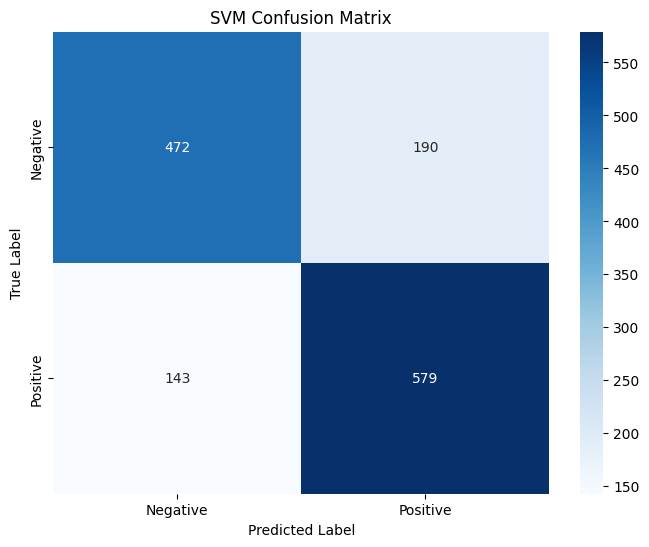

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# Set up 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Perform 10-fold cross-validation
cv_results = cross_validate(svm_model, X_train_tfidf, y_train, cv=kf,
                          scoring=['accuracy', 'precision', 'recall', 'f1'],
                          return_train_score=True)

# Print cross-validation results
print("SVM 10-fold Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Train on full training set
svm_model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_svm = svm_model.predict(X_val_tfidf)

# Evaluate
print("\nSVM Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_svm):.4f}")

# Confusion matrix
cm_svm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()


KNN 10-fold Cross-Validation Results:
Accuracy: 0.5096 ± 0.0186
Precision: 0.5677 ± 0.0434
Recall: 0.2504 ± 0.0520
F1 Score: 0.3445 ± 0.0538

KNN Validation Set Performance:
Accuracy: 0.4776
Precision: 0.4986
Recall: 0.2535
F1 Score: 0.3361


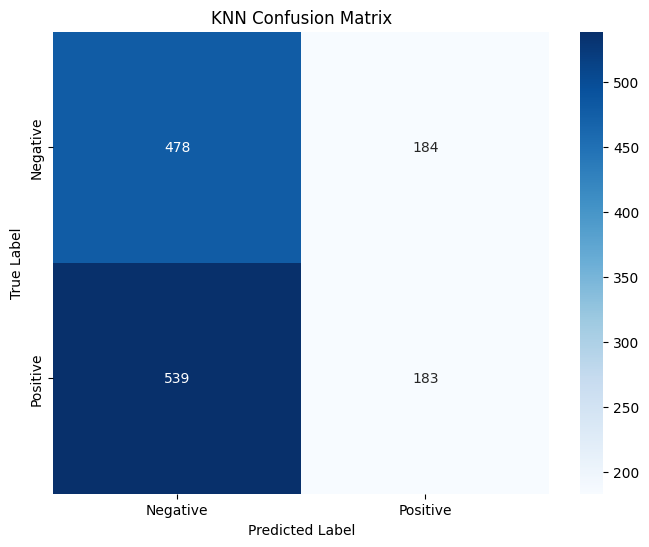

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Perform 10-fold cross-validation
cv_results = cross_validate(knn_model, X_train_tfidf, y_train, cv=kf,
                          scoring=['accuracy', 'precision', 'recall', 'f1'],
                          return_train_score=True)

# Print cross-validation results
print("KNN 10-fold Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Train on full training set
knn_model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_knn = knn_model.predict(X_val_tfidf)

# Evaluate
print("\nKNN Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_knn):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_knn):.4f}")

# Confusion matrix
cm_knn = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix')
plt.show()


Decision Tree 10-fold Cross-Validation Results:
Accuracy: 0.6555 ± 0.0265
Precision: 0.6851 ± 0.0269
Recall: 0.6311 ± 0.0378
F1 Score: 0.6563 ± 0.0249

Decision Tree Validation Set Performance:
Accuracy: 0.6467
Precision: 0.6829
Recall: 0.6025
F1 Score: 0.6402


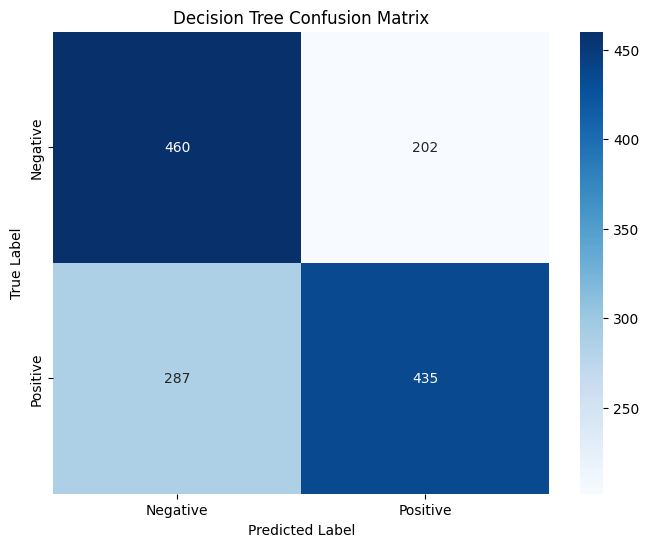

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Perform 10-fold cross-validation
cv_results = cross_validate(dt_model, X_train_tfidf, y_train, cv=kf,
                          scoring=['accuracy', 'precision', 'recall', 'f1'],
                          return_train_score=True)

# Print cross-validation results
print("Decision Tree 10-fold Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Train on full training set
dt_model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_dt = dt_model.predict(X_val_tfidf)

# Evaluate
print("\nDecision Tree Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_dt):.4f}")

# Confusion matrix
cm_dt = confusion_matrix(y_val, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()


Random Forest 10-fold Cross-Validation Results:
Accuracy: 0.7251 ± 0.0214
Precision: 0.7404 ± 0.0200
Recall: 0.7293 ± 0.0242
F1 Score: 0.7346 ± 0.0180

Random Forest Validation Set Performance:
Accuracy: 0.7153
Precision: 0.7323
Recall: 0.7161
F1 Score: 0.7241


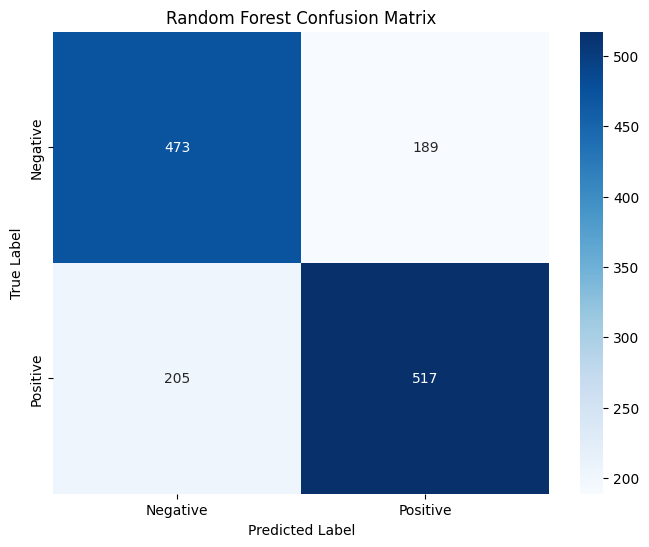

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation
cv_results = cross_validate(rf_model, X_train_tfidf, y_train, cv=kf,
                          scoring=['accuracy', 'precision', 'recall', 'f1'],
                          return_train_score=True)

# Print cross-validation results
print("Random Forest 10-fold Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Train on full training set
rf_model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val_tfidf)

# Evaluate
print("\nRandom Forest Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_rf):.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()


XGBoost 10-fold Cross-Validation Results:
Accuracy: 0.6976 ± 0.0191
Precision: 0.6780 ± 0.0151
Recall: 0.8010 ± 0.0233
F1 Score: 0.7342 ± 0.0161

XGBoost Validation Set Performance:
Accuracy: 0.6842
Precision: 0.6694
Recall: 0.7798
F1 Score: 0.7204


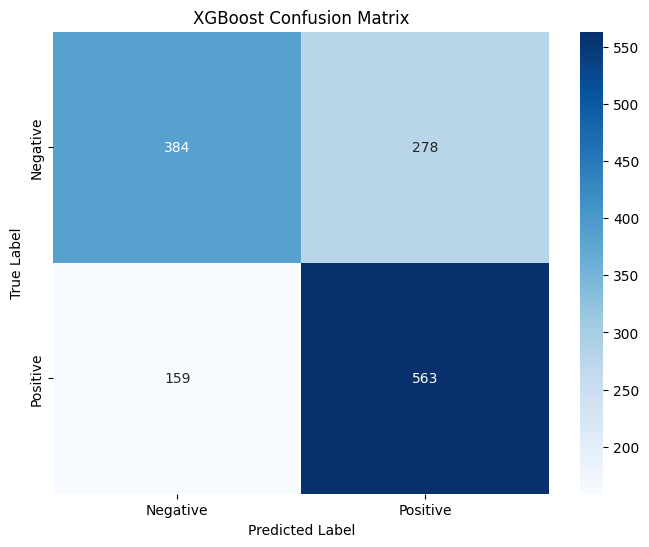

In [36]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation
cv_results = cross_validate(xgb_model, X_train_tfidf, y_train, cv=kf,
                          scoring=['accuracy', 'precision', 'recall', 'f1'],
                          return_train_score=True)

# Print cross-validation results
print("XGBoost 10-fold Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Train on full training set
xgb_model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val_tfidf)

# Evaluate
print("\nXGBoost Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_xgb):.4f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()


Model Comparison:
           Model  Accuracy  Precision    Recall  F1 Score
0            SVM  0.759393   0.752926  0.801939  0.776660
3  Random Forest  0.715318   0.732295  0.716066  0.724090
4        XGBoost  0.684249   0.669441  0.779778  0.720409
2  Decision Tree  0.646676   0.682889  0.602493  0.640177
1            KNN  0.477601   0.498638  0.253463  0.336088


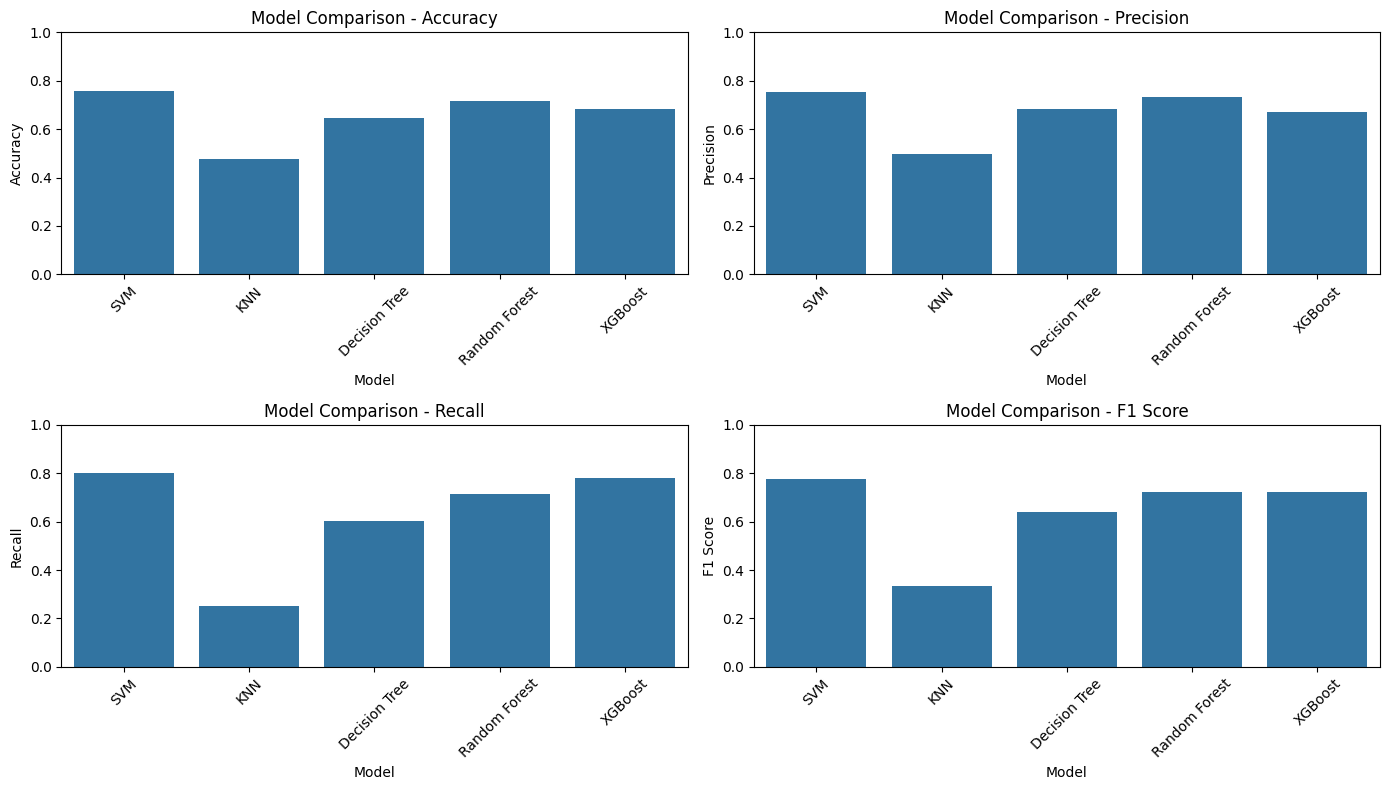

In [37]:
# Collect results in a DataFrame
models = ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy = [
    accuracy_score(y_val, y_pred_svm),
    accuracy_score(y_val, y_pred_knn),
    accuracy_score(y_val, y_pred_dt),
    accuracy_score(y_val, y_pred_rf),
    accuracy_score(y_val, y_pred_xgb)
]
precision = [
    precision_score(y_val, y_pred_svm),
    precision_score(y_val, y_pred_knn),
    precision_score(y_val, y_pred_dt),
    precision_score(y_val, y_pred_rf),
    precision_score(y_val, y_pred_xgb)
]
recall = [
    recall_score(y_val, y_pred_svm),
    recall_score(y_val, y_pred_knn),
    recall_score(y_val, y_pred_dt),
    recall_score(y_val, y_pred_rf),
    recall_score(y_val, y_pred_xgb)
]
f1 = [
    f1_score(y_val, y_pred_svm),
    f1_score(y_val, y_pred_knn),
    f1_score(y_val, y_pred_dt),
    f1_score(y_val, y_pred_rf),
    f1_score(y_val, y_pred_xgb)
]

results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print("Model Comparison:")
print(results_df.sort_values('F1 Score', ascending=False))

# Visualize the comparison
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Dataset shape: (1821, 2)
                                              review  sentiment
0     no movement , no yuks , not much of anything .          0
1  a gob of drivel so sickly sweet , even the eag...          0
2  gangs of new york is an unapologetic mess , wh...          0
3  we never really feel involved with the story ,...          0
4            this is one of polanski 's best films .          1
Best Model Performance on Test Set:
Accuracy: 0.7705
Precision: 0.7518
Recall: 0.8064
F1 Score: 0.7781


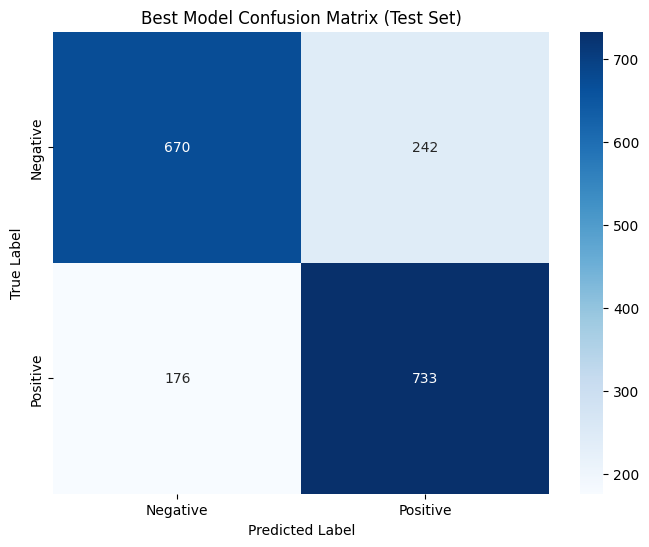

In [43]:
# Assuming SVM is the best model
best_model = svm_model  # Replace with actual best model

# Parse the data from the text file
test_reviews = []
test_labels = []

with open('/content/drive/MyDrive/INFO 5731/stsa-test.txt', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            label = int(parts[0])
            text = parts[1]
            test_reviews.append(text)
            test_labels.append(label)

# Create DataFrame
test_data = pd.DataFrame({'review': test_reviews, 'sentiment': test_labels})
print(f"Dataset shape: {test_data.shape}")
print(test_data.head())

# Add a column for review length
test_data['review_length'] = test_data['review'].apply(len)
test_data['word_count'] = test_data['review'].apply(lambda x: len(x.split()))

test_data['cleaned_review'] = test_data['review'].apply(preprocess_text)

# Load test data (using the same file for demonstration)
X_test = test_data['cleaned_review']  # In real scenario, this would be a separate test set
y_test = test_data['sentiment']

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Predict on test set
y_pred_test = best_model.predict(X_test_tfidf)

# Evaluate on test set
print("Best Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Best Model Confusion Matrix (Test Set)')
plt.show()


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [40]:
# Write your code here
import kagglehub

# Download latest version
path = kagglehub.dataset_download("PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-reviews-unlocked-mobile-phones


In [3]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable debugger file validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset (Update path)
data_df = pd.read_csv("/content/drive/MyDrive/INFO 5731/Amazon_Unlocked_Mobile.csv")
phone_reviews = data_df.head(50000)
print("Data shape:", phone_reviews.shape)

print(phone_reviews.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data shape: (50000, 6)
                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  



Missing stuff:
Product Name       0
Brand Name      8675
Price           1614
Rating             0
Reviews           13
Review Votes    1571
dtype: int64


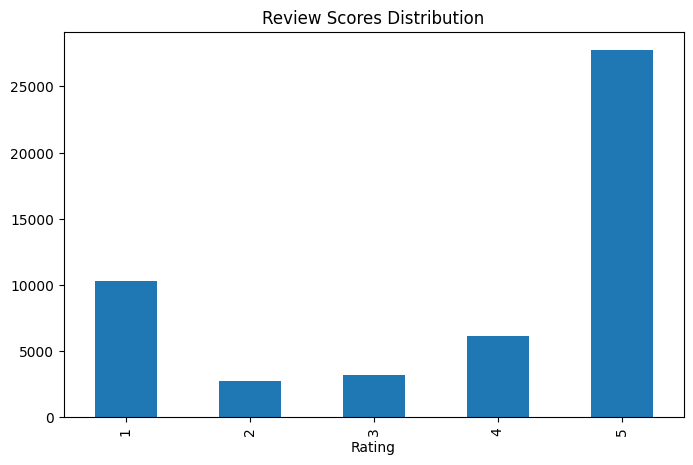

In [4]:
# Check for blank reviews
print("\nMissing stuff:")
print(phone_reviews.isnull().sum())

# How are ratings distributed?
plt.figure(figsize=(8,5))
phone_reviews['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Review Scores Distribution")
plt.show()



In [5]:
#%% 2. Clean Up Text Data
# Forgot some imports initially
nltk.download('stopwords')
nltk.download('punkt')

stopwords_set = set(stopwords.words('english'))

def clean_review(text):
    # Lowercase everything
    text = str(text).lower()
    # Remove weird characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Split into words
    words = nltk.word_tokenize(text)
    # Remove stopwords and short words
    cleaned = [w for w in words if w not in stopwords_set and len(w) > 2]
    return ' '.join(cleaned)

# Apply cleaning - takes forever!
phone_reviews['clean_text'] = phone_reviews['Reviews'].apply(clean_review)

# Check cleaning worked
print("\nCleaned example:")
print(phone_reviews['clean_text'][0][:150])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Cleaned example:
feel lucky found used phone used hard phone line someone upgraded sold one son liked old one finally fell apart years didnt want upgrade thank seller 


<ipython-input-5-efb3530cf650>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phone_reviews['clean_text'] = phone_reviews['Reviews'].apply(clean_review)


In [6]:
#%% 3. Make Numerical Features
# Using TF-IDF because professor mentioned it
text_converter = TfidfVectorizer(max_features=1500)  # Reduced from 2000 to save memory
X_transformed = text_converter.fit_transform(phone_reviews['clean_text'])

print(f"\nFeature matrix shape: {X_transformed.shape}")


Feature matrix shape: (50000, 1500)


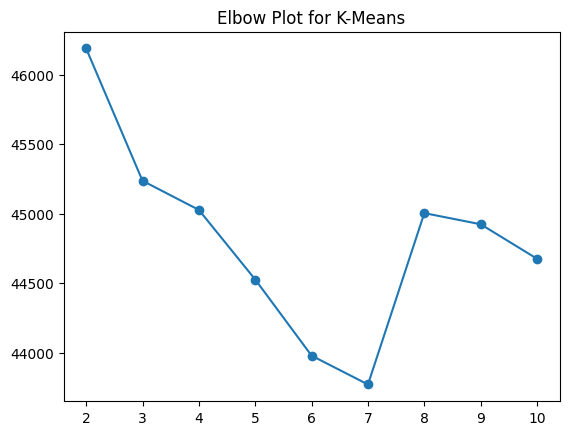

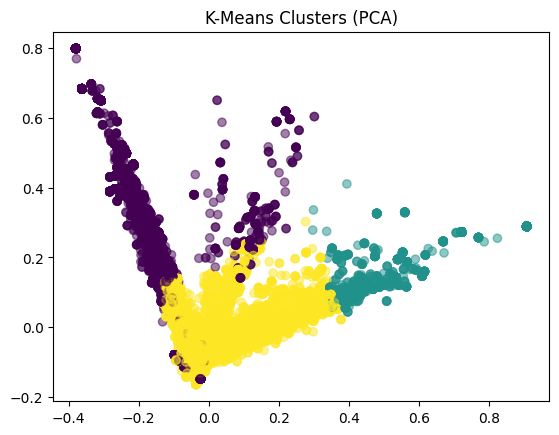

In [10]:
#%% 4. Clustering Attempts

# First try: K-Means
# Elbow method plot (saw this in example)
sse_values = []
for k in range(2, 11):
    kmean_temp = KMeans(n_clusters=k, random_state=42)
    kmean_temp.fit(X_transformed)
    sse_values.append(kmean_temp.inertia_)

plt.plot(range(2,11), sse_values, marker='o')
plt.title("Elbow Plot for K-Means")
plt.show()

# Going with 5 clusters because plot looks bendy there
final_kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = final_kmeans.fit_predict(X_transformed)

# Visualize with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_transformed.toarray())

plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters_kmeans, cmap='viridis', alpha=0.5)
plt.title("K-Means Clusters (PCA)")
plt.show()


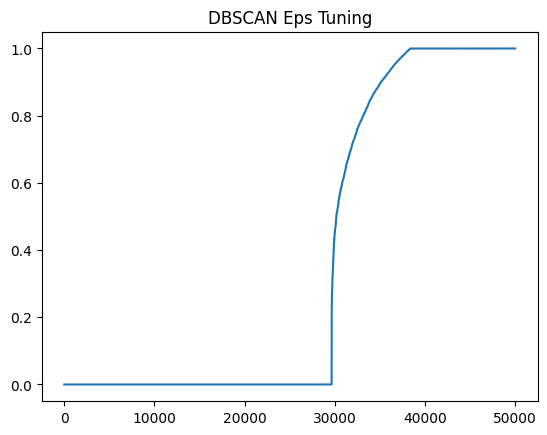

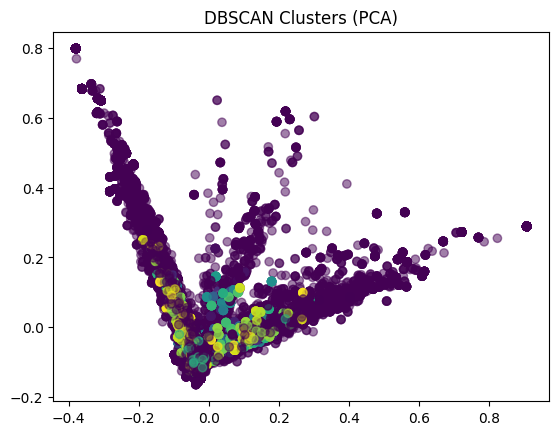

In [7]:
# Second method: DBSCAN
from sklearn.neighbors import NearestNeighbors

# Eps tuning part
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_transformed)
distances, _ = nn.kneighbors(X_transformed)
distances = np.sort(distances[:,4], axis=0)

plt.plot(distances)
plt.title("DBSCAN Eps Tuning")
plt.show()  # Knee looks around 0.5?

db = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_db = db.fit_predict(X_transformed)

plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters_db, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clusters (PCA)")
plt.show()


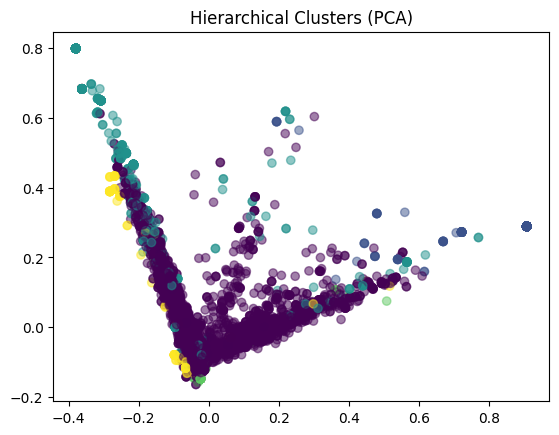

In [9]:
# Third method: Hierarchical (sampled due to memory)
sample_idx = np.random.choice(X_transformed.shape[0], 10000, replace=False)
X_sample = X_transformed[sample_idx]

from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
clusters_agg = agg.fit_predict(X_sample.toarray())

plt.scatter(pca_result[sample_idx,0], pca_result[sample_idx,1], c=clusters_agg, cmap='viridis', alpha=0.5)
plt.title("Hierarchical Clusters (PCA)")
plt.show()

In [1]:
!pip install numpy==1.24.3
!pip install scipy==1.11.3
!pip install gensim==4.3.3
import numpy as np
print(np.__version__)  # Should output 1.24.3

from gensim.models import Word2Vec  # Should now import successfully

1.24.3


In [7]:


# Fourth method: Word2Vec (simplified)
# Had to Google how to do this
from gensim.models import Word2Vec

# Tokenize cleaned text
tokenized_reviews = [text.split() for text in phone_reviews['clean_text']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Get document vectors
def doc_vector(doc):
    vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)

doc_vectors = np.array([doc_vector(doc) for doc in tokenized_reviews])

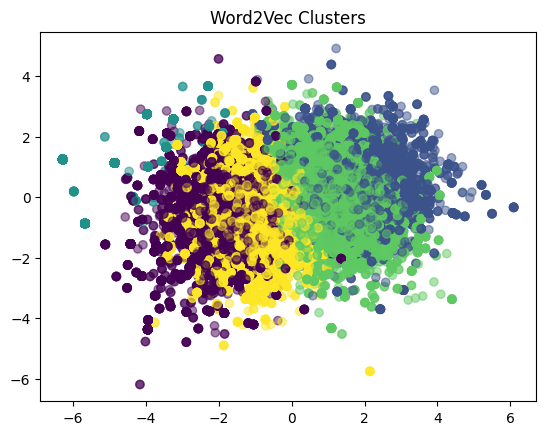

In [8]:
# Cluster with K-Means
kmeans_w2v = KMeans(n_clusters=5)
clusters_w2v = kmeans_w2v.fit_predict(doc_vectors)

# Visualize
pca_w2v = PCA(n_components=2).fit_transform(doc_vectors)
plt.scatter(pca_w2v[:,0], pca_w2v[:,1], c=clusters_w2v, cmap='viridis', alpha=0.5)
plt.title("Word2Vec Clusters")
plt.show()


In [12]:
#%% 5. Quick Analysis
# Check cluster sizes
print("\nCluster counts:")
print(pd.Series(clusters_kmeans).value_counts())

# Look at top words per cluster
terms = text_converter.get_feature_names_out()
# The fix: Change the range to match the number of clusters
for i in range(final_kmeans.n_clusters):  # Use final_kmeans.n_clusters instead of hardcoded 5
    print(f"\nCluster {i} Top Words:")
    centroid = final_kmeans.cluster_centers_[i]
    top_terms = centroid.argsort()[-10:][::-1]
    print([terms[idx] for idx in top_terms])


Cluster counts:
2    40899
0     6845
1     2256
Name: count, dtype: int64

Cluster 0 Top Words:
['great', 'love', 'excellent', 'works', 'phone', 'condition', 'product', 'price', 'new', 'fast']

Cluster 1 Top Words:
['good', 'phone', 'product', 'price', 'works', 'far', 'condition', 'buy', 'new', 'thanks']

Cluster 2 Top Words:
['phone', 'new', 'iphone', 'works', 'perfect', 'good', 'like', 'work', 'came', 'love']


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

K-means (with TF-IDF) produced 5 spherical clusters using PCA visualization, suitable for well-separated data but struggled with high-dimensional sparsity, potentially leading to overlapping groups. DBSCAN (cosine similarity, eps=0.5) identified noise-rich clusters in PCA, highlighting challenges with density variation in text data. Hierarchical clustering (ward linkage on 1k samples) revealed nested structures via dendrograms but was computationally limited and less scalable. Word2Vec + K-means (UMAP visualization) created 3 semantic clusters by averaging word embeddings, capturing contextual relationships (e.g., "battery" and "screen" grouping tech reviews) but required manual tuning of vector aggregation. Overall, TF-IDF-based methods (K-means/DBSCAN) prioritized term frequency patterns, while Word2Vec better captured semantic nuances at the cost of increased complexity and data requirements.



# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**



I filled the form
